# S6. App Structure

## Алгоритм

1. На входе данные за 1 час - показания по экологии и деперсонализированные события по авто
2. Каждый автомобиль получает или теряет баллы в зависимости от показаний экодатчиков в момент проезда
3. Математика начисления баллов (и выставления порогов) модернизируется с каждой итерацией
4. Авто, чьи баллы превысили порог, передаются на обработку экополиции, те возвращаются к нам с информацией о том, какая достигнута точность
5. Повторяем пока не получим нужную точность

## 1. Получение входных данных

1. Отсортировать данные по времени
2. Распределить по локациям
3. Сформировать временные фреймы
4. Упаковать по временным фреймам данные по авто и экологии


In [1]:
import pandas as pd

eco_df = pd.read_csv("ecodata2.csv")
car_df = pd.read_csv("cardata2.csv")

eco_df.sort_values(by=['time'], inplace=True)
car_df.sort_values(by=['time'], inplace=True)

In [2]:
car_df.head(2)

,id,city_id,location_id,camera_id,time,lat,lon,lane,speed
4999,42e4837a-3202-030a-a7e4-11a7d4b8f6d2,2,741,4553,12/10/2022 17:41,43.237604,76.934758,2,10
4858,1162cbfa-b8a3-c2e9-de60-94f9168192dc,2,2,420,12/10/2022 17:41,43.238362,76.889989,3,10


In [3]:
time_from = pd.to_datetime('12/10/22 17:45')
time_to = pd.to_datetime('12/10/22 17:47')

eco_df1 = eco_df.loc[(pd.to_datetime(eco_df['time']) >= time_from) & (pd.to_datetime(eco_df['time']) < time_to)]
eco_df1

,id,city_id,location_id,camera_id,co,no2,so2,o3,pm25,pm10,temp,hum,time,ver,lat,lon,created
3803,12,2,780,4571,11.00,0.00,0,0.70,47,53,18.32,21.32,12/10/22 17:45,-1,43.199581,76.894464,12/10/22 11:45
3804,15,2,2,420,9.39,0.00,0,0.81,43,43,19.09,19.30,12/10/22 17:45,-1,43.238362,76.889989,12/10/22 11:45
3805,14,2,337,1724,14.89,5.40,0,1.08,60,65,19.09,22.58,12/10/22 17:45,-1,43.244170,76.915991,12/10/22 11:45
3806,18,2,741,4553,3.79,0.61,0,0.79,43,52,18.09,21.93,12/10/22 17:45,-1,43.237604,76.934758,12/10/22 11:45
3807,11,2,334,1695,7.90,0.58,0,0.69,38,40,19.46,19.32,12/10/22 17:45,-1,43.235258,76.904510,12/10/22 11:45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3629,13,2,285,1378,3.90,0.07,0,0.22,30,33,17.75,20.23,12/10/22 17:46,-1,43.203173,76.866910,12/10/22 11:46
3630,17,2,802,4429,10.89,0.00,0,1.00,60,65,19.44,21.96,12/10/22 17:46,-1,43.241658,76.937550,12/10/22 11:46
3631,19,2,9,450,6.40,5.96,0,0.00,39,48,17.55,24.37,12/10/22 17:46,-1,43.212825,76.920813,12/10/22 11:46
3632,10,2,781,5779,9.00,5.65,0,0.65,47,50,19.18,20.95,12/10/22 17:46,-1,43.214086,76.898003,12/10/22 11:46


In [4]:
eco_df_420 = eco_df.loc[(pd.to_datetime(eco_df['time']) == pd.to_datetime('12/10/22 17:45')) & (eco_df['camera_id'] == 420)]

car_df_420 = car_df.loc[(pd.to_datetime(car_df['time']) == pd.to_datetime('12/10/22 17:45')) & (car_df['camera_id'] == 420)]

eco_df_420.head(5)

,id,city_id,location_id,camera_id,co,no2,so2,o3,pm25,pm10,temp,hum,time,ver,lat,lon,created
3804,15,2,2,420,9.39,0.0,0,0.81,43,43,19.09,19.30,12/10/22 17:45,-1,43.238362,76.889989,12/10/22 11:45
3813,15,2,2,420,9.30,0.0,0,0.81,43,43,19.09,19.20,12/10/22 17:45,-1,43.238362,76.889989,12/10/22 11:45
3786,15,2,2,420,9.39,0.0,0,0.81,43,43,19.09,19.53,12/10/22 17:45,-1,43.238362,76.889989,12/10/22 11:45
3795,15,2,2,420,9.39,0.0,0,0.81,43,43,19.10,19.44,12/10/22 17:45,-1,43.238362,76.889989,12/10/22 11:45
3831,15,2,2,420,9.30,0.0,0,0.80,43,43,19.07,19.12,12/10/22 17:45,-1,43.238362,76.889989,12/10/22 11:45


In [5]:
car_df_420.head(5)

,id,city_id,location_id,camera_id,time,lat,lon,lane,speed
3804,b8ee6f4c-1d81-3589-d106-ee3a4ea4107f,2,2,420,12/10/2022 17:45,43.238362,76.889989,2,22
3813,5076cd16-cb1a-5028-1a2b-2de7094c59c5,2,2,420,12/10/2022 17:45,43.238362,76.889989,2,32
3786,9b78c8a9-f568-7540-efd9-e32817893cc2,2,2,420,12/10/2022 17:45,43.238362,76.889989,3,37
3795,78575d88-378c-c8ce-9cb0-9f12f5cf84b9,2,2,420,12/10/2022 17:45,43.238362,76.889989,1,0
3831,ff7984a4-f87a-3165-2755-a459bd123d22,2,2,420,12/10/2022 17:45,43.238362,76.889989,3,10


In [6]:
#timeframe420 = pd.DataFrame(car_df_420,eco_df_420)
timeframe420 = pd.concat([car_df_420,eco_df_420],axis=1)
timeframe420.head(10)

,id,city_id,location_id,camera_id,time,lat,lon,lane,speed,id,...,o3,pm25,pm10,temp,hum,time,ver,lat,lon,created
3804,b8ee6f4c-1d81-3589-d106-ee3a4ea4107f,2,2,420,12/10/2022 17:45,43.238362,76.889989,2,22,15,...,0.81,43,43,19.09,19.30,12/10/22 17:45,-1,43.238362,76.889989,12/10/22 11:45
3813,5076cd16-cb1a-5028-1a2b-2de7094c59c5,2,2,420,12/10/2022 17:45,43.238362,76.889989,2,32,15,...,0.81,43,43,19.09,19.20,12/10/22 17:45,-1,43.238362,76.889989,12/10/22 11:45
3786,9b78c8a9-f568-7540-efd9-e32817893cc2,2,2,420,12/10/2022 17:45,43.238362,76.889989,3,37,15,...,0.81,43,43,19.09,19.53,12/10/22 17:45,-1,43.238362,76.889989,12/10/22 11:45
3795,78575d88-378c-c8ce-9cb0-9f12f5cf84b9,2,2,420,12/10/2022 17:45,43.238362,76.889989,1,0,15,...,0.81,43,43,19.10,19.44,12/10/22 17:45,-1,43.238362,76.889989,12/10/22 11:45
3831,ff7984a4-f87a-3165-2755-a459bd123d22,2,2,420,12/10/2022 17:45,43.238362,76.889989,3,10,15,...,0.80,43,43,19.07,19.12,12/10/22 17:45,-1,43.238362,76.889989,12/10/22 11:45
3840,3b1c3ba6-d17e-91ba-7b97-1ebf04b7416a,2,2,420,12/10/2022 17:45,43.238362,76.889989,2,11,15,...,0.80,43,43,19.06,19.13,12/10/22 17:45,-1,43.238362,76.889989,12/10/22 11:45
3822,a3619eac-86f6-c684-c68e-74286aa0d276,2,2,420,12/10/2022 17:45,43.238362,76.889989,3,29,15,...,0.81,43,43,19.08,19.12,12/10/22 17:45,-1,43.238362,76.889989,12/10/22 11:45
3751,3411a265-0f6e-7dd9-8057-736de83452fc,2,2,420,12/10/2022 17:45,43.238362,76.889989,1,14,15,...,0.83,43,43,19.11,19.79,12/10/22 17:45,-1,43.238362,76.889989,12/10/22 11:45
3742,e6459da9-1fa4-6906-ce9c-173ae78dff82,2,2,420,12/10/2022 17:45,43.238362,76.889989,2,8,15,...,0.83,43,43,19.12,19.72,12/10/22 17:45,-1,43.238362,76.889989,12/10/22 11:45
3732,03c79415-15c2-959d-a4ab-1cb94e9ec69a,2,2,420,12/10/2022 17:45,43.238362,76.889989,1,26,15,...,0.83,109,116,19.12,19.65,12/10/22 17:45,-1,43.238362,76.889989,12/10/22 11:45


In [7]:
eco_df_420_all = eco_df.loc[(eco_df['camera_id'] == 420)]

car_df_420_all = car_df.loc[(car_df['camera_id'] == 420)]

timeframe420_all = pd.concat([car_df_420_all,eco_df_420_all],axis=1)
timeframe420_all

,id,city_id,location_id,camera_id,time,lat,lon,lane,speed,id,...,o3,pm25,pm10,temp,hum,time,ver,lat,lon,created
4858,1162cbfa-b8a3-c2e9-de60-94f9168192dc,2,2,420,12/10/2022 17:41,43.238362,76.889989,3,10,15,...,0.87,35,38,19.20,19.29,12/10/22 17:41,-1,43.238362,76.889989,12/10/22 11:41
4849,1ecfb7c6-c5a9-f439-f506-36dfdf97f3c1,2,2,420,12/10/2022 17:41,43.238362,76.889989,2,6,15,...,0.88,35,38,19.19,19.22,12/10/22 17:41,-1,43.238362,76.889989,12/10/22 11:41
4840,3901d7e0-576b-a587-8815-693deb731b32,2,2,420,12/10/2022 17:41,43.238362,76.889989,3,4,15,...,0.88,35,38,19.19,19.18,12/10/22 17:41,-1,43.238362,76.889989,12/10/22 11:41
4883,f1652ccf-e045-bdbc-b7be-b20325afa6d2,2,2,420,12/10/2022 17:41,43.238362,76.889989,1,37,15,...,0.86,35,38,19.18,19.37,12/10/22 17:41,-1,43.238362,76.889989,12/10/22 11:41
4868,7336fbd7-6f12-237f-660a-5de61420999e,2,2,420,12/10/2022 17:41,43.238362,76.889989,1,32,15,...,0.87,35,38,19.19,19.33,12/10/22 17:41,-1,43.238362,76.889989,12/10/22 11:41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,dfdc223a-f014-b16c-571a-d49e299a37e0,2,2,420,12/10/2022 17:59,43.238362,76.889989,2,12,15,...,0.85,41,44,18.61,19.38,12/10/22 17:59,-1,43.238362,76.889989,12/10/22 11:59
199,00378cd9-c65b-e9e7-e45a-3cdb456d2262,2,2,420,12/10/2022 17:59,43.238362,76.889989,1,34,15,...,0.85,41,44,18.63,19.35,12/10/22 17:59,-1,43.238362,76.889989,12/10/22 11:59
191,fc0534c9-4597-13ef-bba9-53f0324c2338,2,2,420,12/10/2022 17:59,43.238362,76.889989,1,34,15,...,0.85,41,44,18.63,19.37,12/10/22 17:59,-1,43.238362,76.889989,12/10/22 11:59
182,325a99b1-4a1e-ac65-b104-40c022f5c1a1,2,2,420,12/10/2022 17:59,43.238362,76.889989,3,39,15,...,0.85,41,44,18.61,19.37,12/10/22 17:59,-1,43.238362,76.889989,12/10/22 11:59


In [8]:
def createTimeframe(time, camera_id):
    eco_df_part = eco_df.loc[(pd.to_datetime(eco_df['time']) == pd.to_datetime(time)) & (eco_df['camera_id'] == camera_id)]
    car_df_part = car_df.loc[(pd.to_datetime(car_df['time']) == pd.to_datetime(time)) & (car_df['camera_id'] == camera_id)]
    return [car_df_part,eco_df_part]

# time_to = pd.to_datetime('12/10/22 17:50')
# timeframe= createTimeframe(time_to,450)
minutes = list(eco_df['time'].unique())
cameras = list(eco_df['camera_id'].unique())
timeframes = []
#timeframes[420] = [createTimeframe(i,420)]
# for i in minutes:
#      # for j in cameras:
#         timeframes[420] = [createTimeframe(i,420)]
for i in minutes:
     for j in cameras:
        timeframes.append(createTimeframe(i,j))
print(minutes)
print(cameras)
# timeframes
print(timeframes[0][1])

['12/10/22 17:41', '12/10/22 17:42', '12/10/22 17:43', '12/10/22 17:44', '12/10/22 17:45', '12/10/22 17:46', '12/10/22 17:47', '12/10/22 17:48', '12/10/22 17:49', '12/10/22 17:50', '12/10/22 17:51', '12/10/22 17:52', '12/10/22 17:53', '12/10/22 17:54', '12/10/22 17:55', '12/10/22 17:56', '12/10/22 17:57', '12/10/22 17:58', '12/10/22 17:59', '12/10/22 18:00']
[4553, 420, 1724, 4571, 5779, 450, 4429, 1378, 1695, 3022]
      id  city_id  location_id  camera_id   co   no2  so2    o3  pm25  pm10  \
4999  18        2          741       4553  4.0  0.68    0  0.81    40    45   
4850  18        2          741       4553  4.0  0.73    0  0.80    32    36   
4841  18        2          741       4553  4.0  0.73    0  0.80    32    36   
4860  18        2          741       4553  4.0  0.72    0  0.80    32    36   
4885  18        2          741       4553  4.0  0.70    0  0.80    32    36   
4876  18        2          741       4553  4.0  0.70    0  0.09    32    36   
4798  18        2          

## 2. Начисление баллов

1. Сформировать хранилище для баллов
2. Подготовить функцию для начисления баллов
3. Прогнать входные данные через функцию начисления баллов по каждой локации фрейм за фреймом

In [9]:
from functools import reduce
import math
score = {'default' : 0}
time_to = pd.to_datetime('12/10/22 17:50')

test = createTimeframe(time_to,420)

temp = test[1]['temp'].tolist()

temp_med = sorted(temp)[len(temp)//2]
temp_avg = sum(temp)/len(temp)

temp_sq = math.sqrt(reduce(lambda a, b: a + (b - temp_avg)**2, temp, 0) / len(temp))
temp_sq_arr = list(map(lambda a: a + temp_sq, temp))
print(temp_avg + temp_sq)

pm = test[1]['pm25'].tolist()

pm_med = sorted(pm)[len(pm)//2]
pm_avg = sum(pm)/len(pm)

pm_sq = math.sqrt(reduce(lambda a, b: a + (b - pm_avg)**2, pm, 0) / len(pm))
pm_sq_arr = list(map(lambda a: a + pm_sq, pm))
print(pm_avg + pm_sq)


19.037225698846942
56.50088654184039


In [34]:
def sq(dateframe):
    temp = dateframe[1]['temp'].tolist()
    temp_med = sorted(temp)[len(temp)//2]
    temp_avg = sum(temp)/len(temp)
    temp_sq = math.sqrt(reduce(lambda a, b: a + (b - temp_avg)**2, temp, 0) / len(temp))
    temp_sq_arr = list(map(lambda a: a + temp_sq, temp))
    pm = dateframe[1]['pm25'].tolist()
    pm_med = sorted(pm)[len(pm)//2]
    pm_avg = sum(pm)/len(pm)
    pm_sq = math.sqrt(reduce(lambda a, b: a + (b - pm_avg)**2, pm, 0) / len(pm))
    pm_sq_arr = list(map(lambda a: a + pm_sq, pm))
    return [temp_avg + temp_sq,pm_avg + pm_sq]

def score_add(timeframe):
    scores= {}
    for i in timeframe:
        score = 0
        s = False
        f = False
        # print(i[0]['id'])
        for j in i[1]['pm25']:
            if j >= sq(timeframe[1])[1]:
                s = True
            else:
                f = True
        if s:
            score +=1
        if f:
            score -=1
            # print(j)
        for j in range(i[0]['id'].size):
            # print(i[0]['id'].iloc[j])
            scores[i[0]['id'].iloc[j]] = score
    # print(scores)
    return scores
test1 = []
for i in minutes:
    test1.append(createTimeframe(i,420))
# test1.append(createTimeframe('12/10/2022 17:41',420))
# sq_temp_test1 = sq_temp(test1[0])
# print(test1[2][0])
# timeframes
print(sq(test1[1]))
# for i in timeframes:
#     print(pd.concat([i[0]['id'],i[1]['pm25']],axis =1))


[19.05180208512308, 39.52952539301212]


In [36]:
a = score_add(timeframes)


In [37]:
# print(test1[0][0]['id'].iloc[1])
score = 1
scores = {}
for j in range(test1[0][0]['id'].size):
    # print(test1[0][0]['id'].iloc[j])
    scores[test1[0][0]['id'].iloc[j]] = score
scores

{'1162cbfa-b8a3-c2e9-de60-94f9168192dc': 1,
 '1ecfb7c6-c5a9-f439-f506-36dfdf97f3c1': 1,
 '3901d7e0-576b-a587-8815-693deb731b32': 1,
 'f1652ccf-e045-bdbc-b7be-b20325afa6d2': 1,
 '7336fbd7-6f12-237f-660a-5de61420999e': 1,
 'e0962049-202b-c4ef-07b9-3ecfdb0ea21e': 1,
 'fb487b7b-1086-7dc4-92bd-765906cc150b': 1,
 '193fd082-5ef6-b5a6-3dd4-ba2a4bb58c47': 1,
 'f868bb55-a04e-d680-64da-8da2f494c851': 1,
 '0bd424bb-66b0-0e80-ab3d-a4f4ebaa54dd': 1,
 '42e2748a-2f14-0c11-b106-1ccd476845da': 1,
 'fe0a893a-fe26-e5c3-56b8-0a02bd036b1a': 1,
 'db7533cb-e39d-b1cd-8a4f-4715ac9b14b1': 1,
 'ec9c7a55-08d0-439f-cc97-d6e0bee9f277': 1,
 'fddcb4ec-c997-1e9a-5a51-0a7870af9fcd': 1,
 'f9e52a01-5914-e83c-3160-41d4135dcc9b': 1,
 'd3f8881f-7825-508d-4c7a-4342760acb71': 1,
 'fa1ed421-234f-0240-a8a1-b4835542fa74': 1,
 'b457bb61-baca-0672-a918-8ac203a562c4': 1,
 'b9919f31-3d30-bb32-6cb9-c5bbb467dc0e': 1,
 '6768c656-e293-9315-9b33-38e49041d0a5': 1,
 '60efd27f-adb4-f58f-86c5-119e15cfef7f': 1,
 '76f2cbfb-18f3-14f2-86c1-7bee2b

['12/10/22 17:50', '12/10/22 17:50', '12/10/22 17:50', '12/10/22 17:50', '12/10/22 17:50', '12/10/22 17:50', '12/10/22 17:50', '12/10/22 17:50', '12/10/22 17:50', '12/10/22 17:50', '12/10/22 17:50', '12/10/22 17:50', '12/10/22 17:50', '12/10/22 17:50', '12/10/22 17:50', '12/10/22 17:50', '12/10/22 17:50', '12/10/22 17:50', '12/10/22 17:50', '12/10/22 17:50', '12/10/22 17:50', '12/10/22 17:50', '12/10/22 17:50', '12/10/22 17:50', '12/10/22 17:50', '12/10/22 17:50', '12/10/22 17:50', '12/10/22 17:50', '12/10/22 17:50']


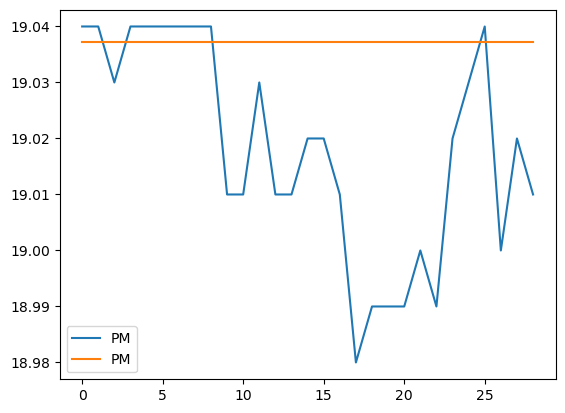

In [38]:
import matplotlib.pyplot as plt
time = test[1]['time'].tolist()
print(time)
ind = range(len(time))
plt.plot(ind, temp, label="PM")
plt.plot(ind, [temp_avg + temp_sq]*len(temp), label="PM")
plt.legend()
plt.show()

## 3. Сохранение результата

Сохранить итоговое значение score в файл формата .csv

In [39]:
a1 = pd.DataFrame(a, index = [0])
a1.T.to_csv('output.csv')